**Changes** - The data directories should be located directly in the data folder, not in subfolders by month. The load_data() function takes in the path to the data directory and the language to filter by (None returns all languages). It returns the data from the directories as a dataframe. I also added some additional data fields from the XML files to the dataframe.

In [22]:
import json
import os
import collections
import io
import numpy as np
import xmltodict
import pandas as pd
import json
import matplotlib.pyplot as plt
import urllib.request
%matplotlib inline

* [TED Schemas](https://publications.europa.eu/en/web/eu-vocabularies/tedschemashttps://publications.europa.eu/en/web/eu-vocabularies/tedschemas)
* [Forms in PDF ](http://simap.ted.europa.eu/standard-forms-for-public-procurement)
* [Daily Notices](https://data.europa.eu/euodp/data/dataset/ted-1/resource/0eec3f91-27f1-4ce0-91d2-102d82cb97ec)

In [29]:
data_path = "../data"

def load_data(data_path, language="EN"):
    # get the list of the subdirectories
    dirs = os.listdir(data_path)
    parsed_xmls = []
    
    language_tenders = []
    all_tenders = []
    
    # loop through the subdirectories and get the list of files in each
    for dir_ in dirs:
        files = os.listdir(os.path.join(data_path, dir_))
        date = dir_.split("_")[0]
        
        # loop through the files
        for file in files:
            if '.xml' not in file:
                continue
                
            # read the contents of the file
            with io.open(os.path.join(data_path, dir_, file), 'r', encoding="utf-8") as f:
                xml = f.read()
                parsed_xml = xmltodict.parse(xml)
                parsed_xmls.append(parsed_xml)
                forms_section = parsed_xml['TED_EXPORT']['FORM_SECTION']
                notice_data = parsed_xml['TED_EXPORT']['CODED_DATA_SECTION']['NOTICE_DATA']
                codif_data = parsed_xml['TED_EXPORT']['CODED_DATA_SECTION']['CODIF_DATA']
                
                forms = forms_section.keys()
                
                for form in forms:
                    try:
                        form_contents = forms_section[form]
                        form_contents['DATE'] = date
                        form_contents['FILE'] = file
                        form_contents['NO_DOC_OJS'] = notice_data['NO_DOC_OJS']
                        form_contents['ORIGINAL_CPV_CODE'] = notice_data['ORIGINAL_CPV']['@CODE']
                        form_contents['ORIGINAL_CPV_TEXT'] = notice_data['ORIGINAL_CPV']['#text']
                        form_contents['VALUE'] = notice_data['VALUES']['VALUE']['#text']
                        form_contents['VALUE_CURR'] = notice_data['VALUES']['VALUE']['@CURRENCY']
                        form_contents['REF_NO'] = notice_data['REF_NOTICE']['NO_DOC_OJS']
                        
                        if isinstance(form_contents, list):
                            for i, form_contents in enumerate(fred):
                                all_tenders.append(form_contents[i])
                                if language is not None and form_contents['@LG'] == language:
                                    language_tenders.append(form_contents[i])
                        elif isinstance(form_contents, collections.OrderedDict):
                            all_tenders.append(form_contents)
                            if language is not None and form_contents['@LG'] == language:
                                language_tenders.append(form_contents)
                    except Exception as e:
                        pass

    if language == None:
        language_tenders = all_tenders

    parsed_data = []
    for tender in language_tenders:
        flattened = {}
        
        # add some fields
        flattened['DATE'] = tender['DATE']
        flattened['LG'] = tender['@LG']
        flattened['FILE'] = tender['FILE']
        flattened['NO_DOC_OJS'] = tender['NO_DOC_OJS']
        flattened['ORIGINAL_CPV_CODE'] = tender['ORIGINAL_CPV_CODE']
        flattened['ORIGINAL_CPV_TEXT'] = tender['ORIGINAL_CPV_TEXT']
        flattened['VALUE'] = tender['VALUE']
        flattened['VALUE_CURR'] = tender['VALUE_CURR']
        flattened['REF_NO'] = tender['REF_NO']
        try:
            for key, value in tender['CONTRACTING_BODY'].items():
                address_contracting_body = value
                try:
                    for key, value in address_contracting_body.items():
                        flattened[key.lower()] = value
                except:
                    pass
            
            flattened['title'] = tender['OBJECT_CONTRACT']['TITLE']['P']
            flattened['short_description'] = tender['OBJECT_CONTRACT']['SHORT_DESCR']['P']
            
            # unwind some fields
            flattened['country'] = flattened['country']['@VALUE']
            flattened['n2016:nuts'] = flattened['n2016:nuts']['@CODE']
            
            parsed_data.append(flattened)
        except Exception as e:
#             print("error:", e)
            pass

    df = pd.DataFrame(parsed_data)

    return df

In [30]:
print(os.getcwd())
df = load_data(data_path, language=None)

/Users/nfreundl/Documents/UIUC/CS498-CCA/Project/notebooks


In [31]:
df.head()

,@value,DATE,FILE,LG,NO_DOC_OJS,ORIGINAL_CPV_CODE,ORIGINAL_CPV_TEXT,REF_NO,VALUE,VALUE_CURR,...,n2016:nuts,nationalid,officialname,phone,postal_code,short_description,title,town,url_buyer,url_general
0,GENERAL_PUBLIC_SERVICES,2019,010177_2019.xml,DE,2019/S 006-010177,71327000,Load-bearing structure design services,2018/S 123-123456,0.01,EUR,...,DE118,NaN,Stadt Gundelsheim,+49 6269-9630,74831,Der Auftrag umfasst die Fachplanungsleistungen...,Neubau einer Kindertageseinrichtung/Fachplanun...,Gundelsheim,NaN,www.Gundelsheim.de
1,PUBLIC_ORDER_AND_SAFETY,2019,010176_2019.xml,DE,2019/S 006-010176,85300000,Social work and related services,2018/S 170-387063,17694423.22,EUR,...,DEA1,NaN,Ministerium des Innern des Landes NRW,+49 211 / 871-01,40217,Dienstleistung „Pädagogische Fachkraft“ für di...,Dienstleistung „Pädagogische Fachkraft“ für di...,Düsseldorf,NaN,www.im.nrw.de
2,BODY_PUBLIC,2019,009154_2019.xml,EN,2019/S 006-009154,50241100,Vessel repair services,2018/S 210-480099,279360,EUR,...,UKM,NaN,CalMac Ferries Ltd,+44 1475650252,PA19 1QP,Upgrade of electric controls for 3 existing ST...,Upgrade of Electrical Controls,Gourock,https://www.publiccontractsscotland.gov.uk/sea...,www.calmac.co.uk
3,RECREATION_CULTURE_AND_RELIGION,2019,009155_2019.xml,EL,2019/S 006-009155,14621000,Ferro-alloys,2018/S 145-331246,233475.89,EUR,...,EL521,NaN,Υπουργείο Πολιτισμού και Αθλητισμού - Εφορεία ...,+30 2331029737,591 32,"Προμήθεια ανοξείδωτου οπλισμού — Τμήμα Β, για ...","«Προμήθεια ανοξείδωτου οπλισμού — Τμήμα Β», γι...",Βέροια,NaN,www.yppo.gr
4,MINISTRY,2019,009666_2019.xml,CS,2019/S 006-009666,55511000,Canteen and other restricted-clientele cafeter...,2018/S 218-499498,2510875.00,CZK,...,CZ01,72080043,Česká republika - Generální finanční ředitelství,+420 296851826,117 22,Předmětem veřejné zakázky je poskytování služe...,Závodní stravování v budově Generálního finanč...,Praha 1,https://nen.nipez.cz/profil/gfrnen,http://www.financnisprava.cz


In [33]:
df.columns

Index(['@value', 'DATE', 'FILE', 'LG', 'NO_DOC_OJS', 'ORIGINAL_CPV_CODE',
       'ORIGINAL_CPV_TEXT', 'REF_NO', 'VALUE', 'VALUE_CURR', 'address',
       'contact_point', 'country', 'e_mail', 'fax', 'n2016:nuts', 'nationalid',
       'officialname', 'phone', 'postal_code', 'short_description', 'title',
       'town', 'url_buyer', 'url_general'],
      dtype='object')

In [71]:
# convert all currencies to EUR
def convert_currencies(values, currencies):
    url = "https://api.exchangeratesapi.io/latest"
    content = urllib.request.urlopen(url).read()
    exchange_rates = json.loads(content.decode())
    results = []
    
    for value, currency in zip(values, currencies):
        if currency == "EUR":
            results.append(value)
            
        else:
            try:
                exchange_rate = exchange_rates['rates'][currency]
                converted_value = float(value) / exchange_rate
                results.append(converted_value)
            # if we don't have a rate for the currency use NaN
            except:
                results.append(np.nan)
                
    return results

df['VALUE_EUR'] = convert_currencies(df['VALUE'].values, df['VALUE_CURR'].values)
df['VALUE_EUR'] = df['VALUE_EUR'].astype(float)

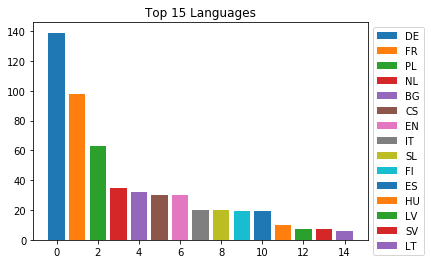

In [72]:
languages = pd.value_counts(df.LG)
for i, lang in enumerate(languages.index[:15]):
    plt.bar(i, languages[lang], label=lang)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title("Top 15 Languages")
plt.show()

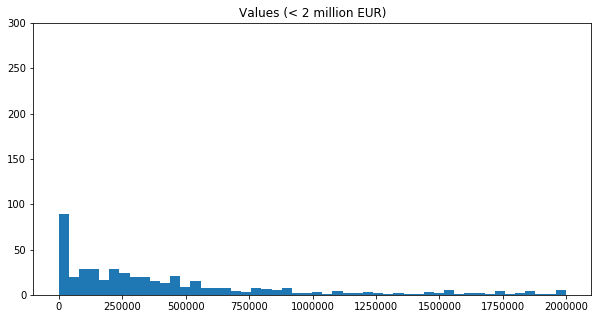

In [73]:
values = df['VALUE_EUR'].astype("float")
plt.figure(figsize=(10,5))
plt.hist(values[values < 2000000] , bins=50)
plt.title("Values (< 2 million EUR)")
plt.ylim(0, 300)
plt.show()

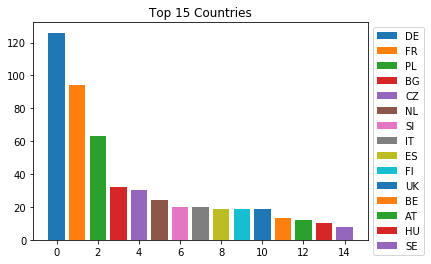

In [74]:
countries = pd.value_counts(df['country'])
for i, country in enumerate(countries.index[:15]):
    plt.bar(i, countries[country], label=country)
    
plt.legend(bbox_to_anchor=(1,1))
plt.title("Top 15 Countries")
plt.show()

## Group by country by value

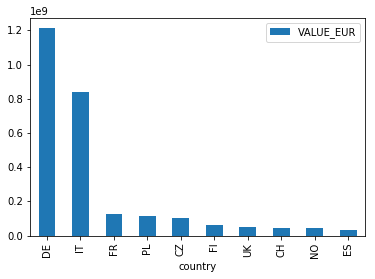

In [116]:
df_q3_1 = df[["country", 'VALUE_EUR']]
df_q3_2 = df_q3_1.groupby(['country'], as_index=False).sum().sort_values(by=['VALUE_EUR'], ascending=False).reset_index()
df_q3_2.head(10).plot(x = 'country', y = 'VALUE_EUR', kind='bar')